# COGS 108 - Final Project: Household income and Covid rates; connected?

https://youtu.be/FjOWwZ_HUvE

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [ X ] NO - keep private

# Overview

In this project our group did an analysis to see if household income has any connection to an individuals COVID-19 contract rate. From this project we found their to be a connection between the two. We saw that the lower someone's income is, the higher their chance of contracting covid is.

# Names

- Albert Henderson
- Yixuan Jiao
- Antonio (Jose) Gomez
- Dat Ta

<a id='research_question'></a>
# Research Question

Do Americans living in poor households (income below U.S. Federal Poverty threshold) get/contract Covid at a higher rate?

<a id='background'></a>

## Background & Prior Work


COVID-19 started in the beginning of 2020. After 2 years of mandatory mask policies, social distancing and vaccinations to help fight the virus we still see the affect of COVID-19 across the country. As college students our social and learning life has been very different. We are looking forward to investing if different household incomes effect COVID-19 infection rates across the United States.


References (include links):
- 1) https://www.who.int/health-topics/coronavirus#tab=tab_1
- 2) https://covid.cdc.gov/covid-data-tracker/#datatracker-home

# Hypothesis


Hypothesis: If a region is low income then they are impacted more by COVID-19

Prediction: The poorer the region is, the more negatively effected they are by COVID-19 (higher infection rate and death rate)

# Dataset(s)

We will be using the poverty counts and percentages of each county and compare that with the number of covid cases across different counties throughout the country in order to determine if poverty affect covid cases. To do this we chose to analyze 3 large datasets, 1 from the New York Times and 2 from the U.S. Census Bureau with over a total of 100,000 observations-before cleaning it up.

- Dataset Name: NYT Covid 19 states data (us-states.csv)
- Link to the dataset: https://github.com/nytimes/covid-19-data/blob/master/us-states.csv
- Number of observations: 43910 (each state will have accumulated observation by date)
- This dataset gives the number of cases and deaths in each states from 2020-2022


- Dataset Name: 2020-2021 estimate population by counties
- Link to the dataset: https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv
- Number of observations: 3194
- This dataset gives the 2020-2021 population of each county in the US


- Dataset Name: 2020 Small Area Income and Poverty Estimates (SAIPE)
- Link to the dataset: https://www.census.gov/data-tools/demo/saipe/#/?map_geoSelector=aa_c
- Number of observations: 3195
- This dataset has the small area income and estimates of poverty in those areas




# Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

# Data Cleaning

To clean the population and poverty data sets from the U.S. Census Bureau, we eliminated any rows with missing observations, removed a significant amount of columns we didnt need for our analysis and made sure each one was of the appropriate data type. Then renamed the columns.

For the New York Times data set the table was already very clean. With only five columns, each of which describing variables necessary for our analysis, such as; location, date, cases and deaths.

Then we merged our data sets to create a new DataFrame. After, we noticed that cases and deaths are highly related to the population size and needed to be normalized by state population.

In [2]:
# Loading states covid data
# A county covid dataset are also available under the same resporitory, we could retrieve it as we need following the same procedure like retrieving this one.
covid_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
covid_states.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [3]:
covid_states.shape

(45646, 5)

In [4]:
#it is already very clean table
covid_states.isnull().values.any()

False

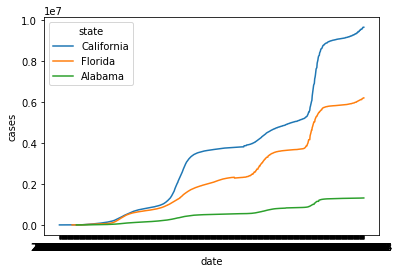

In [5]:
#plotting some states' cases over data further more validate the dataset since this trend make sense and that reminds us to get some population dataset to normalize the count.
covid_states_sub = covid_states[covid_states['state'].isin(['California','Florida','Alabama'])]
states_lineplot = sns.lineplot(x = covid_states_sub['date'], y = covid_states_sub['cases'], hue = covid_states_sub['state'])

In [6]:
#choose the current cases for each state
covid_states = covid_states.drop('fips',axis = 1)
covid_states = covid_states.groupby('state').agg('max').reset_index()
covid_states.head()

,state,date,cases,deaths
0,Alabama,2022-06-05,1317029,19664
1,Alaska,2022-06-05,261117,1246
2,American Samoa,2022-06-05,6053,31
3,Arizona,2022-06-05,2062669,30332
4,Arkansas,2022-06-05,845946,11498


In [7]:
#Loading population dataset
county_population = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv',encoding='latin-1')

In [8]:
county_population.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,...,RESIDUAL2021,GQESTIMATESBASE2020,GQESTIMATES2020,GQESTIMATES2021,RBIRTH2021,RDEATH2021,RNATURALCHG2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021
0,40,3,6,1,0,Alabama,Alabama,5024279,5024803,5039877,...,242,114572,114572,114572,11.191613,12.890226,-1.698613,0.247201,4.398749,4.645950
1,50,3,6,1,1,Alabama,Autauga County,58805,58877,59095,...,8,442,442,442,11.002611,11.545112,-0.542502,0.084766,4.017903,4.102668
2,50,3,6,1,3,Alabama,Baldwin County,231767,233140,239294,...,-82,2177,2177,2177,9.567474,12.137145,-2.569671,0.266704,28.702422,28.969126
3,50,3,6,1,5,Alabama,Barbour County,25223,25180,24964,...,1,2789,2789,2789,10.928526,15.714742,-4.786216,0.039885,-3.908743,-3.868858
4,50,3,6,1,7,Alabama,Bibb County,22293,22223,22477,...,-1,2062,2062,2062,10.111857,12.617450,-2.505593,0.089485,13.825503,13.914989


In [9]:
county_population.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021',
       'NPOPCHG2020', 'NPOPCHG2021', 'BIRTHS2020', 'BIRTHS2021', 'DEATHS2020',
       'DEATHS2021', 'NATURALCHG2020', 'NATURALCHG2021',
       'INTERNATIONALMIG2020', 'INTERNATIONALMIG2021', 'DOMESTICMIG2020',
       'DOMESTICMIG2021', 'NETMIG2020', 'NETMIG2021', 'RESIDUAL2020',
       'RESIDUAL2021', 'GQESTIMATESBASE2020', 'GQESTIMATES2020',
       'GQESTIMATES2021', 'RBIRTH2021', 'RDEATH2021', 'RNATURALCHG2021',
       'RINTERNATIONALMIG2021', 'RDOMESTICMIG2021', 'RNETMIG2021'],
      dtype='object')

In [10]:
county_population.shape

(3194, 35)

In [11]:
#Selecting columns we desire
county_population = county_population.iloc[:,[5,6,8,9]]
county_population.columns = ['state','county','pop_estimate_2020','pop_estimate_2021']
county_population.head()

,state,county,pop_estimate_2020,pop_estimate_2021
0,Alabama,Alabama,5024803,5039877
1,Alabama,Autauga County,58877,59095
2,Alabama,Baldwin County,233140,239294
3,Alabama,Barbour County,25180,24964
4,Alabama,Bibb County,22223,22477


In [12]:
county_population.isnull().values.any()

False

In [13]:
#found some states' population stats in that we potentially need that
state_population = county_population[county_population['county'] == county_population['state']]
state_population.head()

,state,county,pop_estimate_2020,pop_estimate_2021
0,Alabama,Alabama,5024803,5039877
68,Alaska,Alaska,732441,732673
99,Arizona,Arizona,7177986,7276316
115,Arkansas,Arkansas,3012232,3025891
191,California,California,39499738,39237836


In [14]:
# loading in poverty dataset
# Here using the absolute directory from github folder, so make sure having the following csv file in the same directory with the notebook.
poverty_df = pd.read_csv('./SAIPESNC_18MAY22_16_38_35_19.csv')
poverty_df.head()

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),All Ages in Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),Median Household Income in Dollars,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,2020,0,0,United States,"321,478,113","38,371,394","38,309,115","38,433,673","38,309,115 to 38,433,673",11.9,...,"3,158,914","3,133,736 to 3,158,914",16.8,16.7,16.9,16.7 to 16.9,"$67,340","$67,251","$67,429","$67,251 to $67,429"
1,2020,1,1000,Alabama,"4,799,999","714,568","695,249","733,887","695,249 to 733,887",14.9,...,"70,797","61,541 to 70,797",23.3,21.7,24.9,21.7 to 24.9,"$53,958","$53,013","$54,903","$53,013 to $54,903"
2,2020,1,1001,Autauga County (AL),"55,622","6,242","4,930","7,554","4,930 to 7,554",11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,"$67,565","$59,132","$75,998","$59,132 to $75,998"
3,2020,1,1003,Baldwin County (AL),"226,513","20,189","15,535","24,843","15,535 to 24,843",8.9,...,NaN,NaN,NaN,NaN,NaN,NaN,"$71,135","$66,540","$75,730","$66,540 to $75,730"
4,2020,1,1005,Barbour County (AL),"21,745","5,548","4,210","6,886","4,210 to 6,886",25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,"$38,866","$33,510","$44,222","$33,510 to $44,222"


In [15]:
poverty_df.shape, poverty_df.columns

((3195, 44),
 Index(['Year', 'State', 'County ID', 'State / County Name',
        'All Ages SAIPE Poverty Universe', 'All Ages in Poverty Count',
        'All Ages in Poverty Count LB 90%', 'All Ages in Poverty Count UB 90%',
        '90% Confidence Interval (All Ages in Poverty Count)',
        'All Ages in Poverty Percent', 'All Ages in Poverty Percent LB 90%',
        'All Ages in Poverty Percent UB 90%',
        '90% Confidence Interval (All Ages in Poverty Percent)',
        'Under Age 18 SAIPE Poverty Universe', 'Under Age 18 in Poverty Count',
        'Under Age 18 in Poverty Count LB 90%',
        'Under Age 18 in Poverty Count UB 90%',
        '90% Confidence Interval (Under Age 18 in Poverty Count)',
        'Under Age 18 in Poverty Percent',
        'Under Age 18 in Poverty Percent LB 90%',
        'Under Age 18 in Poverty Percent UB 90%',
        '90% Confidence Interval (Under Age 18 in Poverty Percent)',
        'Ages 5 to 17 in Families SAIPE Poverty Universe',
        '

In [16]:
# removing unecessary columns
poverty_df = poverty_df.drop(columns=['Year','All Ages SAIPE Poverty Universe',\
                 'All Ages in Poverty Count LB 90%', 'All Ages in Poverty Count UB 90%',\
                 '90% Confidence Interval (All Ages in Poverty Count)',
                 'All Ages in Poverty Percent LB 90%',
                 'All Ages in Poverty Percent UB 90%',
                 '90% Confidence Interval (All Ages in Poverty Percent)',
                 'Under Age 18 SAIPE Poverty Universe',
                 'Under Age 18 in Poverty Count LB 90%',
                 'Under Age 18 in Poverty Count UB 90%',
                 '90% Confidence Interval (Under Age 18 in Poverty Count)',
                 'Under Age 18 in Poverty Percent LB 90%',
                 'Under Age 18 in Poverty Percent UB 90%',
                 '90% Confidence Interval (Under Age 18 in Poverty Percent)',
                 'Ages 5 to 17 in Families SAIPE Poverty Universe',
                 'Ages 5 to 17 in Families in Poverty Count',
                 'Ages 5 to 17 in Families in Poverty Count LB 90%',
                 'Ages 5 to 17 in Families in Poverty Count UB 90%',
                 '90% Confidence Interval (Ages 5 to 17 in Families in Poverty Count)',
                 'Ages 5 to 17 in Families in Poverty Percent',
                 'Ages 5 to 17 in Families in Poverty Percent LB 90%',
                 'Ages 5 to 17 in Families in Poverty Percent UB 90%',
                 '90% Confidence Interval (Ages 5 to 17 in Families in Poverty Percent)',
                 'Under Age 5 SAIPE Poverty Universe', 'Under Age 5 in Poverty Count',
                 'Under Age 5 in Poverty Count LB 90%',
                 'Under Age 5 in Poverty Count UB 90%',
                 '90% Confidence Interval (Under Age 5 in Poverty Count)',
                 'Under Age 5 in Poverty Percent',
                 'Under Age 5 in Poverty Percent LB 90%',
                 'Under Age 5 in Poverty Percent UB 90%',
                 '90% Confidence Interval (Under Age 5 in Poverty Percent)',
                 'Median Household Income in Dollars LB 90%',
                 'Median Household Income in Dollars UB 90%',
                 '90% Confidence Interval (Median Household Income in Dollars)'])

poverty_df.head()

,State,County ID,State / County Name,All Ages in Poverty Count,All Ages in Poverty Percent,Under Age 18 in Poverty Count,Under Age 18 in Poverty Percent,Median Household Income in Dollars
0,0,0,United States,"38,371,394",11.9,"11,204,423",15.7,"$67,340"
1,1,1000,Alabama,"714,568",14.9,"222,934",20.9,"$53,958"
2,1,1001,Autauga County (AL),"6,242",11.2,"1,912",14.9,"$67,565"
3,1,1003,Baldwin County (AL),"20,189",8.9,"5,907",12.4,"$71,135"
4,1,1005,Barbour County (AL),"5,548",25.5,"1,857",37.5,"$38,866"


In [17]:
# filtering to only select state information
state_id = []
for x in range(57):
    state_id.append(x * 1000)
poverty_df = poverty_df[poverty_df.loc[:,'County ID'] % 1000 == 0]

In [18]:
#rename the columns
poverty_df = poverty_df.reset_index().drop(['index','State','County ID'],axis = 1)
poverty_df = poverty_df.drop(0)
poverty_df.columns = ['state','all_ages_poverty_count','all_ages_poverty_pct','under_18_poverty_count','under_18_poverty_pct','median_household_income']

In [19]:
#changing non-numeric types into int
poverty_df['median_household_income'] = poverty_df['median_household_income'].str.replace('$','')
poverty_df['median_household_income'] = poverty_df['median_household_income'].str.replace(',','')
poverty_df['median_household_income'] = pd.to_numeric(poverty_df['median_household_income'])
poverty_df['all_ages_poverty_count'] = poverty_df['all_ages_poverty_count'].str.replace(',','')
poverty_df['all_ages_poverty_count'] = pd.to_numeric(poverty_df['all_ages_poverty_count'])
poverty_df['under_18_poverty_count'] = poverty_df['under_18_poverty_count'].str.replace(',','')
poverty_df['under_18_poverty_count'] = pd.to_numeric(poverty_df['under_18_poverty_count'])

/var/folders/6t/5985wf8d6x7fl9lz6_r5s97r0000gn/T/ipykernel_19647/1184632771.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  poverty_df['median_household_income'] = poverty_df['median_household_income'].str.replace('$','')


In [20]:
poverty_df.head()

,state,all_ages_poverty_count,all_ages_poverty_pct,under_18_poverty_count,under_18_poverty_pct,median_household_income
1,Alabama,714568,14.9,222934,20.9,53958
2,Alaska,68714,9.6,21459,12.3,79961
3,Arizona,932555,12.8,283667,17.6,64652
4,Arkansas,448665,15.2,142855,20.8,51146
5,California,4419167,11.5,1260145,14.6,83001


# Data Analysis & Results

Here we use OLS to see if there's significant relationship between varaibles and which variables may have a significant influence.

Looking at poverty_percentage VS infection_rate and death rate. From this we can see that there's positive correlation between covid infection and poverty. So for states that have a higher poverty percentage there is also a higher number of infections.

Next we look across our data from all 50 states in terms of infection rate against median household income. This time there is a negative correlation in the data. Meaning household with higher income are less likely to contract Covid.

The graphs below support our hypothesis that Covid have a higher impact on households that are in poverty but not a very strong one.

Firstly, a whole dataframe is created by merging all 3 dataframe we got so far. Each state is an observation and their related data is listed as variable in columns shown below.

In [21]:
#Creating DataFrame for EDA
eda_df = covid_states.merge(state_population,how = 'inner',on = 'state')
eda_df = eda_df.merge(poverty_df,how = 'inner',on = 'state')
eda_df.head()

,state,date,cases,deaths,county,pop_estimate_2020,pop_estimate_2021,all_ages_poverty_count,all_ages_poverty_pct,under_18_poverty_count,under_18_poverty_pct,median_household_income
0,Alabama,2022-06-05,1317029,19664,Alabama,5024803,5039877,714568,14.9,222934,20.9,53958
1,Alaska,2022-06-05,261117,1246,Alaska,732441,732673,68714,9.6,21459,12.3,79961
2,Arizona,2022-06-05,2062669,30332,Arizona,7177986,7276316,932555,12.8,283667,17.6,64652
3,Arkansas,2022-06-05,845946,11498,Arkansas,3012232,3025891,448665,15.2,142855,20.8,51146
4,California,2022-06-05,9661160,91660,California,39499738,39237836,4419167,11.5,1260145,14.6,83001


The distribution of number of cases and deaths are plotted. We realize it is variable that is highly related to the population and need to be normalized if we want to use it for the further analysis.

<AxesSubplot:xlabel='deaths', ylabel='Count'>

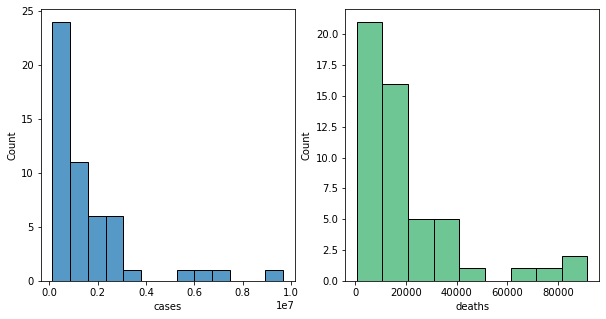

In [22]:
#the cases and deaths are highly related to the population size so are needed to be normalized
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(ax=axes[0], data = eda_df, x = 'cases')

sns.histplot(ax=axes[1], data = eda_df, x = 'deaths', color = 'mediumseagreen')

We normalize the cases and deaths count by states population to get a infection/death rate. Furthermore, we calculating over 18 poverty percent from the total poverty count and the under 18 poverty count. Now we have all variables to conduct the regression analysis.

In [23]:
#First, normalize the number of cases and deaths by states population
eda_df['avg_pop_estimate'] = (eda_df['pop_estimate_2020'] + eda_df['pop_estimate_2021'])/2
eda_df['cases_rate'] = 100*eda_df['cases']/eda_df['avg_pop_estimate']
eda_df['deaths_rate'] = 100*eda_df['deaths']/eda_df['avg_pop_estimate']
#Add a subgroup called over_18_poverty_pct from all_ages_poverty_count and avg_pop_estimate columns
eda_df['over_18_poverty_pct'] = 100*(eda_df['all_ages_poverty_count'] - eda_df['under_18_poverty_count'])/eda_df['avg_pop_estimate']
#drop the count column we don't need now (using percentage for the rest of the analyssis)
eda_df = eda_df.drop(columns=['pop_estimate_2020','pop_estimate_2021', 'under_18_poverty_count','all_ages_poverty_count'])
eda_df.head()

,state,date,cases,deaths,county,all_ages_poverty_pct,under_18_poverty_pct,median_household_income,avg_pop_estimate,cases_rate,deaths_rate,over_18_poverty_pct
0,Alabama,2022-06-05,1317029,19664,Alabama,14.9,20.9,53958,5032340.0,26.171304,0.390753,9.769491
1,Alaska,2022-06-05,261117,1246,Alaska,9.6,12.3,79961,732557.0,35.644598,0.170089,6.450693
2,Arizona,2022-06-05,2062669,30332,Arizona,12.8,17.6,64652,7227151.0,28.540555,0.419695,8.978476
3,Arkansas,2022-06-05,845946,11498,Arkansas,15.2,20.8,51146,3019061.5,28.020165,0.380847,10.129307
4,California,2022-06-05,9661160,91660,California,11.5,14.6,83001,39368787.0,24.540152,0.232824,8.024179


The cases and deaths after normalization is normal enough for now and other variables all look normal too. So the assumption of conducting linear regression is satisfied.

<AxesSubplot:xlabel='deaths_rate', ylabel='Count'>

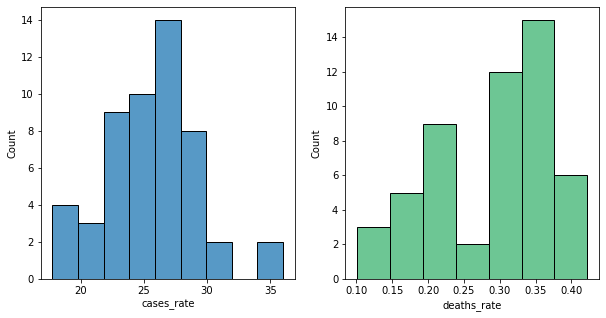

In [24]:
#Normalized rate looks normal now from histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(ax=axes[0], data = eda_df, x = 'cases_rate')

sns.histplot(ax=axes[1], data = eda_df, x = 'deaths_rate', color = 'mediumseagreen')

<AxesSubplot:xlabel='median_household_income', ylabel='Count'>

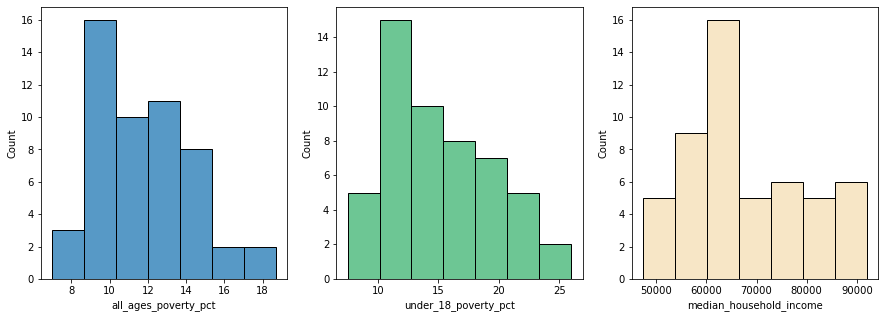

In [25]:
#rest of the variables looks normal
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(ax=axes[0], data = eda_df, x = 'all_ages_poverty_pct')

sns.histplot(ax=axes[1], data = eda_df, x = 'under_18_poverty_pct',color = 'mediumseagreen')

sns.histplot(ax=axes[2], data = eda_df, x = 'median_household_income',color = 'wheat')

Before starting the regression analysis, we use scatter matrix first to see scatter plot between each 2 possible variables we got so far to see if there are some relationship that we need to specificly focus on.

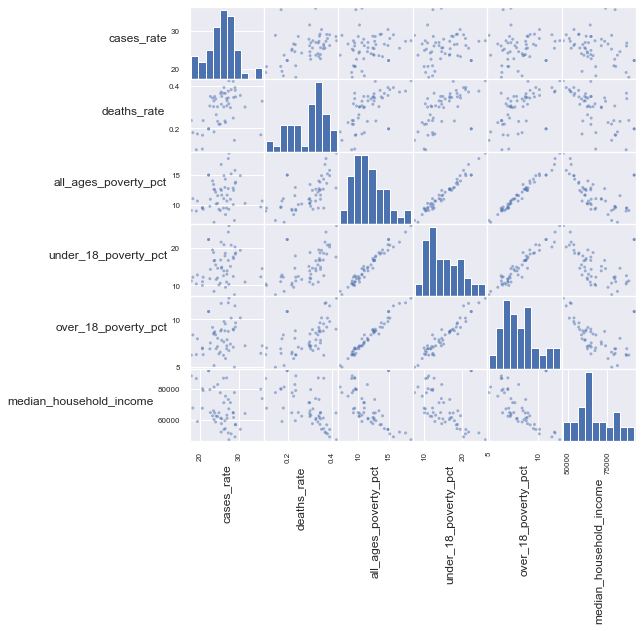

In [26]:
#Searching some possible relationship using scatter matrix
sns.set(rc={'figure.figsize':(8,8)})
fig = pd.plotting.scatter_matrix(eda_df[['cases_rate','deaths_rate','all_ages_poverty_pct','under_18_poverty_pct','over_18_poverty_pct','median_household_income']])
for ax in fig.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
#decribe the plot here: some variables are just natrually correlated like all_ages_poverty_pct and under_18_poverty_pct and median

There are some relatinoships that are natrually related like those variables related to poverty rate. But there are also some relationships we care about seems showing a linear relationship. Our nex step is to display them and simulate the regression line.

<AxesSubplot:xlabel='median_household_income', ylabel='deaths_rate'>

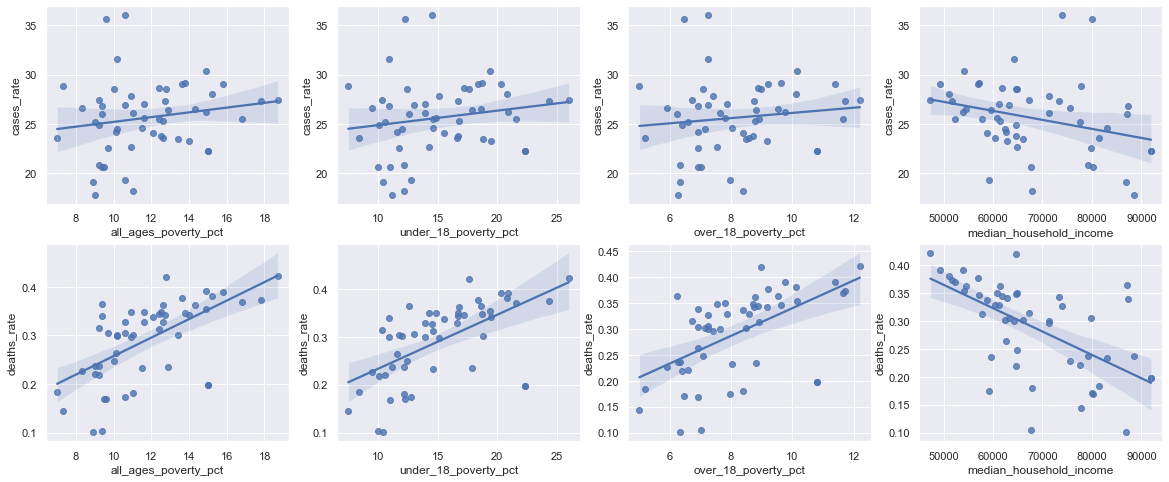

In [27]:
#some relationships we are interseted in
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

sns.regplot(ax = axes[0,0], data = eda_df, x = 'all_ages_poverty_pct',y = 'cases_rate')

sns.regplot(ax = axes[1,0], data = eda_df, x = 'all_ages_poverty_pct',y = 'deaths_rate')

sns.regplot(ax = axes[0,1], data = eda_df, x = 'under_18_poverty_pct',y = 'cases_rate')

sns.regplot(ax = axes[1,1], data = eda_df, x = 'under_18_poverty_pct',y = 'deaths_rate')

sns.regplot(ax = axes[0,2], data = eda_df, x = 'over_18_poverty_pct',y = 'cases_rate')

sns.regplot(ax = axes[1,2], data = eda_df, x = 'over_18_poverty_pct',y = 'deaths_rate')

sns.regplot(ax = axes[0,3], data = eda_df, x = 'median_household_income',y = 'cases_rate')

sns.regplot(ax = axes[1,3], data = eda_df, x = 'median_household_income',y = 'deaths_rate')

## Analysis and Observation

First two-rows we are looking at the poverty_percentage against infection_rate and death rate. From this we can see that there's positive correlation between covid infection vs poverty percentage. What this mean is that for states that have higher poverty percentage there is also a higher number of infection.

Next we look at infection rate against median household income. This time there is a negative correlation in the data. Meaning household with higher income are lesslikely to contract Covid. Across our data for 50 states, there is a slight increase in infection rates for a median income of 50,000 to 90,000 dollars.



The graph seems showing the positive/negative relationship we desire. But are they all statistically significant enough? We conduct OLS here to examine those correlations.

In [28]:
#This part use OLS to see if there's significant relationship between varaibles
#See which varibale may have significant influence in cases_rate
dependent, predictor = patsy.dmatrices('cases_rate ~ all_ages_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             cases_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.483
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.229
Time:                        18:29:37   Log-Likelihood:                -141.15
No. Observations:                  52   AIC:                             286.3
Df Residuals:                      50   BIC:                             290.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               22.7790 

In [29]:
dependent, predictor = patsy.dmatrices('cases_rate ~ under_18_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             cases_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.498
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.227
Time:                        18:29:38   Log-Likelihood:                -141.14
No. Observations:                  52   AIC:                             286.3
Df Residuals:                      50   BIC:                             290.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               23.3950 

In [30]:
dependent, predictor = patsy.dmatrices('cases_rate ~ over_18_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             cases_rate   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7325
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.396
Time:                        18:29:39   Log-Likelihood:                -141.53
No. Observations:                  52   AIC:                             287.1
Df Residuals:                      50   BIC:                             291.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              23.4636    

In [31]:
dependent, predictor = patsy.dmatrices('cases_rate ~ median_household_income', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             cases_rate   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     4.534
Date:                Mon, 06 Jun 2022   Prob (F-statistic):             0.0382
Time:                        18:29:39   Log-Likelihood:                -139.66
No. Observations:                  52   AIC:                             283.3
Df Residuals:                      50   BIC:                             287.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [32]:
#See which varibale may have significant influence on deaths_rate
dependent, predictor = patsy.dmatrices('deaths_rate ~ all_ages_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            deaths_rate   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     30.28
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           1.28e-06
Time:                        18:29:40   Log-Likelihood:                 69.330
No. Observations:                  52   AIC:                            -134.7
Df Residuals:                      50   BIC:                            -130.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0669 

In [33]:
dependent, predictor = patsy.dmatrices('deaths_rate ~ under_18_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            deaths_rate   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     28.22
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           2.51e-06
Time:                        18:29:42   Log-Likelihood:                 68.656
No. Observations:                  52   AIC:                            -133.3
Df Residuals:                      50   BIC:                            -129.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1202 

In [34]:
dependent, predictor = patsy.dmatrices('deaths_rate ~ over_18_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            deaths_rate   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     22.60
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           1.73e-05
Time:                        18:29:43   Log-Likelihood:                 66.718
No. Observations:                  52   AIC:                            -129.4
Df Residuals:                      50   BIC:                            -125.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0728    

In [35]:
dependent, predictor = patsy.dmatrices('deaths_rate ~ median_household_income', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            deaths_rate   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     28.81
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           2.07e-06
Time:                        18:29:44   Log-Likelihood:                 68.849
No. Observations:                  52   AIC:                            -133.7
Df Residuals:                      50   BIC:                            -129.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

The OLS analysis here list out related variables that we care about. Some vairables do have relationship between them and some other may not have teh significant relationship we expected due to the large p-value. But some descent conclusion can be drawn from the regression plot and OLS analysis. They are listed in the conclusion section.

# Ethics & Privacy

- When looking for datasets to use for this project, one of the main concerns that we had to account for was making sure that people's personal information was being used in the datasets along with not mentioning any of the people who have died to COVID-19. The datasets that we used didn't comprimise people's privacy in anyway. 

- The predictions that are made from this analysis shouldn't have any bias within them since data like population and estimate of people in poverty are from the government and not from a survey done by a non-government affiliated organization. 

- We also wanted to make sure that the analysis that we were doing wouldn't have any negative affects on the people it being done on. Since this analysis brings light to the disparity in covid contraction rates between higher and lower household incomes, we decided that this analysis was actually beneficial. Since it can be used to advocate for better treatment for people who do not have the means to pay for better access to health care.

- All of the information used in the analysis if open to public as well so the information used was ethically obtained


# Conclusion & Discussion

From the the analysis we do see a positive correlation between covid infection rates and regions below the poverty line however, the correlation was found to not be statistically significant. 

In general and on a sliding scale, our results suggest households with higher income are lesslikely to contract Covid. For example, households with incomes between \$50,000 and $90,000 dollars were found to have a negative correlation.

In conclusion, our findings do not fully support our hypothesis of impoverished households in the U.S. having higher rates of infection.<br>

OLS Results; <br>

Conclusion 1: Median household income of region may affect the infection rate and death rate (per $1000 of median income, the infection rates decrease by 0.09% and decrease death rate by 0.004%, according to significant p-value)<br>

Conclusion 2: A significant relationship between poverty percent of a region and its corresponding infection rates was not found, even though they exist on our graph. The "all ages poverty percent" seems to positievly correlate with the "deaths_rate" according to its small p-value (1 more percent of poverty of a region may increase its deaths rate by 0.0191%).<br>

Another finding is that the poverty percentage of the over 18 group has a much larger effect on death rate than the under 18 group, suggesting that age could possibly be a co-factor.<br>

# Team Contributions

Albert Henderson: Final report and Video <br>
Yixuan Jiao: Finding dataset, data cleaning, EDA, and conclusion <br>
Dat Ta: Data cleaning, data gathering and analysis <br>
Antonio Gomez: Final report